Prediction of stock prices using XGBoost and technical indicators

Introduction: By employing technical indicators as features, this kernel uses XGBRegressor from the XGBoost library to forecast future stock prices. For explanations of the indicators used in this analysis, such as moving averages, RSI, and MACD, I recommend reading articles on Investopedia or exploring my accompanying notebook, where I present and illustrate different concepts of technical analysis.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ksedataset/PKSLC.csv
/kaggle/input/ksedataset/IBLHL.csv
/kaggle/input/ksedataset/JOVC.csv
/kaggle/input/ksedataset/PIBTL.csv
/kaggle/input/ksedataset/FATIMA.csv
/kaggle/input/ksedataset/FECTC.csv
/kaggle/input/ksedataset/PGHE.csv
/kaggle/input/ksedataset/ICPXXIV.csv
/kaggle/input/ksedataset/SRSM.csv
/kaggle/input/ksedataset/DSML.csv
/kaggle/input/ksedataset/KCORP.csv
/kaggle/input/ksedataset/ICIBL.csv
/kaggle/input/ksedataset/OLPL.csv
/kaggle/input/ksedataset/BNWM.csv
/kaggle/input/ksedataset/CSAP.csv
/kaggle/input/ksedataset/CHBL.csv
/kaggle/input/ksedataset/DICL.csv
/kaggle/input/ksedataset/FFL.csv
/kaggle/input/ksedataset/KSE-MI30.csv
/kaggle/input/ksedataset/GTYR.csv
/kaggle/input/ksedataset/ABOT.csv
/kaggle/input/ksedataset/GLAXO.csv
/kaggle/input/ksedataset/NORS.csv
/kaggle/input/ksedataset/CSIBL.csv
/kaggle/input/ksedataset/PMRS.csv
/kaggle/input/ksedataset/RMCP.csv
/kaggle/input/ksedataset/QUICE.csv
/kaggle/input/ksedataset/AGIL.csv
/kaggle/input/ksedataset/PREMA.

A number of data processing and file handling tasks are performed by this code snippet. 

The first step is to import numpy and assign it the alias "np." Numpy provides support for arrays and matrices in Python. Additionally, it imports the pandas library and gives it the alias "pd." Pandas is a powerful tool for manipulating and analyzing structured data. 
Afterward, the code imports the os module, which provides a way to interact with the operating system. In this case, it is used to handle files and directories. 

The code then traverses a directory ("/kaggle/input") and its subdirectories, retrieving information about each file within, using a for loop and os.walk(). An additional for loop iterates over the list of filenames returned by os.walk(). 
Using the os.path.join() function, the code prints the full path to each file by joining the directory name and the filename. The purpose of this step is to check and verify whether files are available in the specified directory. 
A comment states that any results written to the current directory will be saved as output. 
The code imports necessary libraries, searches for files in a specific directory, and prints their paths. A reminder is also provided about where the output will be saved.

In [2]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


#!pip install numpy scipy patsy pandas
#!pip install statsmodels
# Time series decomposition
#!pip install stldecompose
#from stldecompose import decompose
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,1,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

print(os.listdir("../input"))

['ksedataset']


The following code snippet includes import statements and configuration settings for several Python libraries and modules. 
It imports the xgboost library and assigns it the alias "xgb." XGBoost is a popular gradient boosting library. 
It then imports the matplotlib.pyplot module and assigns it the alias "plt." Matplotlib is a widely used plotting library in Python. 
In addition, the code imports components from XGBoost, such as plot_importance and plot_tree, for visualizing feature importances and decision trees. 
Additionally, several components from the scikit-learn library are imported, such as mean_squared_error for evaluating regression models, MinMaxScaler for scaling numerical features, train_test_split for dividing data into training and testing sets, and GridSearchCV for tuning hyperparameters through cross-validation. 
Using the "!pip install" syntax, certain packages are then installed. Numpy, scipy, patsy, pandas, and statsmodels are among these packages. A variety of statistical and data manipulation functions are provided by these packages. 
Additionally, it imports the decompose function from the stldecompose package for time series decomposition. 
The code imports components from the plotly library and assigns them appropriate aliases for chart drawing and visualization. Using Plotly, you can create interactive and visually appealing plots. 
To avoid cluttering the output, the code mutes scikit-learn warnings. 
Plotly notebook mode is initialized to display charts in the current kernel environment. 
Additionally, plotly.graph_objects is used to define a custom layout for visualizations to modify the default background color. 
To verify that files are available, the code prints a list of files in the "../input" directory. 
This code snippet sets up the necessary imports, configurations, and installations of libraries and modules for machine learning, plotting, statistical analysis, and data manipulation.

Firstly, I read the historical data frame for the stock I intend to analyze (e.g., CERN). Over a period of more than 10 years, the dataset obtained includes day-by-day price history from the New York Stock Exchange. 
To streamline the data processing and analysis, I narrowed the time frame to 2010 to simplify the analysis. Consequently, fewer data points need to be processed, resulting in a more manageable dataset for further analysis. 
The rows of data outside the desired timeframe were then removed. The purpose of this step is to ensure that only the relevant data from the chosen time period remains for analysis. 
To maintain a clean and organized structure, I reindexed the data frame. As a result of this reindexing operation, the data are arranged in a consistent and sequential manner, making subsequent analysis easier.

In [3]:
df= pd.read_csv("../input/ksedataset/FATIMA.csv")
df.head()

Symbol         Date   Open   High    Low  Close    Volume
0  FATIMA  08-Mar-2010  12.93  13.59  12.85  13.34  20170750
1  FATIMA  09-Mar-2010  13.48  13.48  12.90  13.00   2694829
2  FATIMA  10-Mar-2010  13.10  13.19  12.71  12.77   1168442
3  FATIMA  11-Mar-2010  12.95  13.20  12.61  12.69   3115052
4  FATIMA  12-Mar-2010  12.87  12.88  12.50  12.56   1400592

The following code snippet performs two main operations on a dataset. 

Using the pandas library, it reads a CSV file. "../input/ksedataset/FATIMA.csv" is the path to the file. This code imports the contents of the CSV file into a pandas DataFrame by using the pandas "read_csv()" function. DataFrames are tabular data structures that facilitate data manipulation and analysis. 
The code uses the DataFrame's "head()" method after reading the CSV file and creating the DataFrame. The first few rows of the dataset are displayed using this method. It displays the top five rows by default, giving a concise overview. 
You can use this preview of the data to understand the dataset's structure and examine the initial values. The tool allows quick evaluation of column names, data types, and a sample of the actual values. 
The code reads a CSV file into a pandas DataFrame and displays the first rows of the dataset. Getting a glimpse of the data's structure and content facilitates its subsequent analysis and exploration.

I begin by creating an OHLC chart (open/high/low/close) to gain insight into historical prices. For each trading day, this chart depicts the opening price, the highest price, the lowest price, and the closing price. I can observe the price movements and patterns over time by plotting these data points. 
Besides the OHLC chart, I also create a volume chart. The chart shows the number of stocks traded each day. I can identify potential trends or anomalies by visualizing the volume of trading activity. 
The significance of OHLC and Volume charts in technical analysis was discussed in a previous notebook (referenced above). As a result of this analysis, you will gain a comprehensive understanding of how to interpret market behavior, identify support and resistance levels, and make informed trading decisions using these charts. 
This code generates an OHLC chart to visualize historical prices and a Volume chart to represent trading activity. In addition to providing insights into price movements and market dynamics, these charts are valuable tools for technical analysis.

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

Using Plotly, this code snippet creates a visual representation of data. To display an OHLC (open/high/low/close) chart and a Volume chart, it generates a figure with two subplots arranged vertically (two rows and one column). 
Using Plotly's go.Ohlc trace type, an OHLC chart is added to the first subplot. OHLC chart x-axis values are taken from the "Date" column of DataFrame "df". DataFrame columns provide the open, high, low, and close values for each data point. As a result, the OHLC chart provides a graphical representation of the price movements over time. 
Using the go.Scatter trace type, a scatter plot is added to the second subplot. The x-axis values are again taken from the "Date" column, while the y-axis values are taken from the "Volume" column. On this Volume chart, the number of stocks traded each day is shown. 
The code updates the layout of the figure after adding the traces to the subplots. Specifically, it hides the x-axis range slider, removing the interactive slider that enables zooming and panning. 
Using the "show()" method, the code displays the generated figure. It allows for the visual analysis and interpretation of historical price and trading volume data using the OHLC chart and Volume chart. 
The code generates a figure with two subplots: an OHLC chart illustrating price movement and a Volume chart showing trading volume. Using the resulting figure, traders can analyze historical price trends and trading activity.

Composition

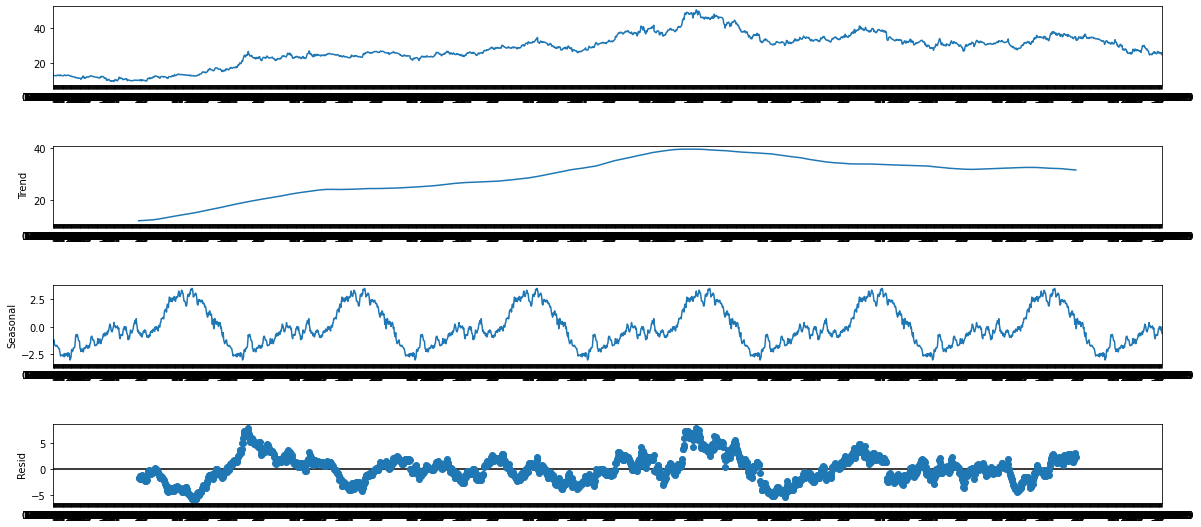

In [5]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

The code in this section performs a time series decomposition and generates a plot showing the decomposed components. 

By selecting only the "Date" and "Close" columns from the original DataFrame "df", a new DataFrame called "df_close" is created. Copy() creates a new copy of the DataFrame. In order to facilitate time-based operations, the "df_close" DataFrame is set to have the "Date" column as its index. 
The "seasonal_decompose()" function is then applied to the "df_close" DataFrame. It decomposes the time series data into four components: trend, seasonality, residuals, and observations. By decomposing the data, underlying patterns and fluctuations can be revealed. 
Using the "plot()" method of the decomposed object, the code generates a plot of the decomposed components. This plot shows the original time series along with the trend, seasonality, and residual components. 
The "set_size_inches()" method is used to adjust the size of the figure, setting the width to 20 inches and height to 8 inches. 
Essentially, this code performs time series decomposition on "Close" prices, generating a plot that displays trend, seasonality, and residual components. Time series data are visualized in this way to help understand underlying patterns and fluctuations.

As technical indicators, I compute several moving averages in this code. Specifically, I calculate Simple Moving Averages (SMA) for periods of 5, 10, 15, and 30, as well as Exponential Moving Averages (EMA) for periods of 9 and 12. 

In technical analysis, moving averages are used to smooth out price data and identify trends. A Simple Moving Average is calculated by adding up the closing prices over a specified number of periods and dividing by the number of periods. To obtain multiple moving averages, this calculation is repeated for different periods. 
On the other hand, the Exponential Moving Average assigns different weights to prices based on their recency. Compared to the Simple Moving Average, it responds faster to price changes due to the weighting of recent data points. 
These moving averages allow us to capture different aspects of price trends and fluctuations over time. Based on the observed patterns, these indicators can be used to analyze historical data and potentially make predictions or decisions.

In [6]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

Using the provided dataset, this code calculates and visualizes various technical indicators. 
Using the closing prices from the dataset, the code calculates the Exponential Moving Average (EMA) with a period of 9. The exponentially weighted moving average (ewm) assigns more weight to recent prices when computing the EMA. To align the EMA values with the corresponding dates, the values are first shifted by one period. 
Using the rolling mean function (rolling), the code calculates Simple Moving Averages (SMA) for different periods (5, 10, 15, and 30). In the rolling mean, the closing prices over a specific period or window are averaged. As with the EMA, the SMA values are also shifted by one period. 
Using the Plotly library, the code generates a plot using the moving averages. An empty figure is used as the plot's initialization. Multiple traces (lines) are then added to the figure, each representing a different moving average or the original closing price. The x-axis represents the dataset dates, while the y-axis represents the corresponding moving averages or closing prices. 
The plot is displayed using the "show()" method, allowing visual examination and analysis of the moving averages alongside the original closing prices. 
Using the provided dataset, this code calculates and visualizes various moving averages (EMA and SMA). Plotting these moving averages provides insight into trends and patterns in the data.

The Relative Strength Index (RSI) indicator will be used to determine whether a stock is overbought or oversold. 

In order to determine if a stock is overextended, the RSI measures the magnitude of recent price changes. In addition, it provides insight into the stock's current strength and potential reversal points. 
I can determine whether a stock is overbought or oversold by calculating the RSI. The RSI value above a certain threshold (typically 70) indicates overbought conditions, indicating a potential price correction or reversal. A value below another threshold (usually 30) indicates the stock is oversold, indicating a potential buying opportunity. 
By incorporating the RSI indicator into the analysis, it is possible to better understand the stock's current market conditions and potential trading opportunities. Making informed decisions about an overbought or oversold stock aids in predicting potential price movements.

In [7]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

The Relative Strength Index (RSI) is calculated and incorporated into the dataset analysis in this code snippet. 
It defines a function called "relative_strength_idx" that takes a DataFrame (df) as input, along with an optional parameter (n) that specifies the period length for RSI calculation. The period length is set to 14 by default. There are several steps involved in calculating the RSI. 
The function extracts the "Close" prices from the DataFrame as a separate series. Then, it computes the differences between consecutive closing prices, referred to as "delta." Positive and negative price changes are separated into two series: "pricesUp" and "pricesDown." Any negative values are set to zero in the "pricesUp" series. In contrast, the "pricesDown" series keeps only the negative price changes, setting the positive values to zero. 
On the "pricesUp" and "pricesDown" series, the code uses the "rolling" method to calculate the rolling mean. Over the specified period (n), the rolling mean of "pricesUp" is calculated. The rolling mean of "pricesDown" is calculated similarly. The rolling means represent the average of positive and negative price changes. 
As a result, the relative strength (rs) is calculated by dividing the rolling mean of "pricesUp" by the rolling mean of "pricesDown." The RSI is then calculated by using the rs value, using the formula: RSI = 100.0 - (100.0 / (1.0 + rs)). 
To the original DataFrame (df), RSI values are added as a new column called 'RSI'. The "fillna()" method fills in missing values in the RSI column with zeros. 
Plotly is then used to create a figure. An RSI scatter plot is added to the figure, where the x-axis represents the dates from the DataFrame, and the y-axis represents the RSI values. 
With the "show()" method, the RSI values can be viewed and analyzed visually. 
This code calculates the RSI for a dataset and integrates it into the analysis. Displaying the RSI values provides insight into the stock's relative strength and potential overbought or oversold conditions.

CMD

In [8]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

For the given dataset, this code snippet calculates and visualizes the Moving Average Convergence Divergence (MACD) indicator. 
The first step is to calculate the Exponential Moving Averages (EMAs). It is calculated by applying the exponential moving average function (ewm) to the 'Close' prices from the dataset, with a span of 12 and a minimum number of periods of 12. Similarly, the EMA_26 is calculated using a minimum of 26 periods and a span of 26 periods. 
By subtracting the EMA_26 values from the EMA_12 values, the MACD line is calculated. MACD is represented by this difference. 
The MACD analysis is further refined by generating a signal line. The MACD line is calculated using the exponential moving average function with a minimum of 9 periods and a span of 9. MACD signal line is represented by the resulting series. 
Using the make_subplots function, a figure with two subplots is created. In the first subplot, the 'Close' prices are shown alongside the EMA_12 and EMA_26 lines. MACD line and MACD signal line are presented in the second subplot. 
For each series of interest, scatter plots are added to the figure. There is a specific subplot for each scatter plot. 
Finally, the MACD indicator and its components are visualized using the show() method. 
For a given dataset, this code calculates the MACD indicator and its signal line. This generates a plot with two subplots, showing the 'Close' prices, the EMA lines, and the MACD indicator. Visualizing the MACD indicator helps understand trends and potential trading signals.

I shift the label column in order to predict the next day's price. I shift the Close price column by -1 rows after calculating all the features for a particular day, denoted as "Di.". Consequently, the features on day "Di" will be aligned with the price on day "Ci+1." When the Close price column is shifted, the price for day "Di" will become the price for day "Ci+1." By aligning features and labels, a supervised learning setting can be created. In this way, features from the same timestamp, such as RSIi, can be used to predict the price for the next day. 
As a result, the shift operation on the label column facilitates the training and evaluation of machine learning models to predict the future price based on the current features.

In [9]:
df['Close'] = df['Close'].shift(-1)


DataFrame's 'Close' column is shifted by this code snippet. 
Shifting one position moves the values of the 'Close' column. The shift is applied in a forward direction with a shift of -1. As a result, each value in the 'Close' column is moved one position up, aligning each value with the following row. 
In this manner, the value originally in row N of the 'Close' column will now be in row N+1. As a result of this shift, each value is advanced to the next row, resulting in the 'Close' column reflecting the next day's closing prices. 
When working with time series data, this operation is commonly used to align features and labels. By shifting the 'Close' column, the DataFrame is adjusted so that each row corresponds to a particular day, and the corresponding 'Close' value reflects the following day's price. 
By shifting the values of the 'Close' column one position, each value is aligned with the following day's closing price. When working with time series data, this ensures proper alignment of features and labels.

This code removes invalid samples from the dataset to ensure data integrity and accuracy. 

A number of rows may contain invalid values as a result of the calculation of moving averages and the shifting of the label column. Since there are insufficient preceding data points, the SMA10 (Simple Moving Average with a period of 10) may not be valid for the first 10 rows. The last row's price may also be erroneously set to 0 after shifting the Close price column. 
The dataset is cleansed of any data points that may cause inconsistencies or misinterpretations when these invalid samples are removed. The purpose of this step is to maintain the accuracy and reliability of the data for analysis or modeling in the future. 
The code identifies and removes invalid samples from the dataset, including rows with incomplete moving average calculations and the last row with an incorrect Close price. In this way, the dataset's integrity is ensured and the analysis is more reliable.

In [10]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

By adjusting the DataFrame's indices and removing specific rows, this code snippet manipulates the DataFrame. 
DataFrames begin with 33 rows; this line removes the first 33 rows. Moving averages and MACD lines are calculated using this operation. For these calculations, the DataFrame is aligned with the relevant data points by removing these initial rows. 
A second code line, `df = df[:-1]`, removes the last row from the DataFrame. The close price column has been shifted, so this removal is necessary. As a result of the shift operation, the last row's close price no longer represents the price of the following day. As a result, removing this row ensures consistency in the data. 
Last but not least, the code assigns new indices to the DataFrame using the range(len(df)) expression. Reindexing resets the indices to a continuous numerical sequence starting at 0. After removing rows from a DataFrame, it is beneficial to maintain a clean and consistent index structure. 
As a result of moving average calculations, MACD line considerations, and the shifting of the close price column, this code adjusts the DataFrame by removing certain rows that are no longer valid or relevant. To ensure a coherent indexing scheme, the indices of the DataFrame are reassigned.

I split the stock data frame into three subsets: training (70%) validation (15%) and test (15%). The split indices were calculated and three separate frames (train_df, valid_df, test_df) were created. The chart below plots all three frames.

In [11]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

On the basis of specified proportions, this code splits the data into training, validation, and test sets. 
In the first two lines of code, the proportions for the test set (test_size) and validation set (valid_size) are defined as percentages. According to these proportions, the test and validation sets should be the same size as the whole dataset. 
Based on the specified proportions, the next two lines calculate the split indices. Valid_split_idx represents the index where the dataset will be split between the validation and training sets, and test_split_idx represents the index where the dataset will be split for the test set. 
These split indices are then used to create three separate DataFrames: train_df, valid_df, and test_df. Data from the start of the dataset up to the valid_split_idx (inclusive) are included in the train_df DataFrame. The valid_df DataFrame represents the validation set between valid_split_idx+1 and test_split_idx (inclusive). The test_df DataFrame represents the test set from test_split_idx+1 onwards. 
The code creates a plot using Plotly after splitting the dataset. Each scatter trace represents the closing prices for the training, validation, and test sets. On the x-axis are the dates from the respective DataFrames, while on the y-axis are the closing prices for those dates. 
To visualize and analyze the training, validation, and test sets, the plot is displayed using the "show()" method. 
Based on specified proportions, this code divides the dataset into training, validation, and test sets. A plot is generated to visualize the closing prices of each set over time by creating separate DataFrames for each set. As a result, the data can be visually understood and further analyzed.

Remove unnecessary columns from the table


In [12]:
drop_cols = ['Date', 'Symbol','Volume', 'Open', 'Low', 'High']  #Date,Open,High,Low,Close,Volume,OpenInt

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)


The following code snippet removes specific columns from the training, validation, and test DataFrames. 
"drop_cols" contains a list of column names that should be removed from DataFrames. Columns include 'Date', 'Symbol', 'Volume', 'Open', 'Low', and 'High'. For subsequent analysis or modeling, these columns may have been deemed unnecessary. 
Each DataFrame is then dropped using the "drop()" function, with the "drop_cols" list specified and the axis parameter set to 1. Columns are dropped instead of rows when the axis parameter value is 1. 
The specified columns are removed from the respective DataFrames when these lines of code are executed. For further analysis or modeling, only the relevant features or variables are retained in modified DataFrames. 
This code removes specific columns from training, validation, and test DataFrames. Columns listed in "drop_cols" are dropped from each DataFrame, resulting in modified DataFrames. As a result, a streamlined dataset with the desired features can be created for analysis or modeling.

Labels and features

In [13]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 8 columns):
EMA_9          1620 non-null float64
SMA_5          1620 non-null float64
SMA_10         1620 non-null float64
SMA_15         1620 non-null float64
SMA_30         1620 non-null float64
RSI            1620 non-null float64
MACD           1620 non-null float64
MACD_signal    1620 non-null float64
dtypes: float64(8)
memory usage: 101.4 KB


In this code snippet, the target variable and the features are separated from the training, validation, and test datasets. 
Y_train is assigned the 'Close' column from the training DataFrame (train_df). The 'Close' column represents the target variable, which is what we want to predict. Copy() ensures that the target variable is stored independently. 
By removing the 'Close' column from the training DataFrame, the second line creates a new DataFrame, X_train. The remaining columns in this DataFrame represent the features used to train the predictive model. 
The next two lines perform similar operations on the validation and test datasets. Assigning the 'Close' column to the variables y_valid and y_test, respectively, represents the target variables for the validation and test sets. Similarly, X_valid and X_test are created by removing the 'Close' column from the validation and test DataFrames. 
Last but not least, the code calls the 'info()' method on the X_train DataFrame. There is information provided about the DataFrame, including the data types of the columns, the number of non-null values, and the amount of memory used. 
The code separates the training, validation, and test datasets from the target variable ('Close'). Y_train, Y_valid, and Y_test store the target variables, while X_train, X_valid, and X_test store the corresponding features. During model training and evaluation, the target variable and features can be handled independently. In order to explore and verify the data, the X_train.info() line provides information about the features of the training set.

The XGBoostRegressor needs to be fine-tuned

In [14]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.3145888976435081
CPU times: user 24min 7s, sys: 14.1 s, total: 24min 21s
Wall time: 6min 18s


An XGBoost regression model is tuned using grid search with cross-validation. 
"%%time" is a magic command in Jupyter Notebook that measures the execution time of the following code block. 
During the grid search process, different hyperparameter values can be explored in the "parameters" dictionary. Hyperparameters include 'n_estimators' (number of estimators), 'learning_rate', 'max_depth' (maximum depth of trees), 'gamma' (minimum loss reduction for splitting), and 'random_state' (random seed for reproducibility). 
During training, the "eval_set" list defines the evaluation sets. The training set (X_train, Y_train) and validation set (X_valid, Y_valid) are included. 
With the specified evaluation sets and objective function set to 'reg:squarederror' (squared error regression loss), a new XGBoost regression model is instantiated. To limit the output verbosity during training, the "verbose" parameter is set to False. 
Grid search with cross-validation is performed using the "GridSearchCV" class from scikit-learn. GridSearchCV tunes the model object based on the defined parameters. 
To find the best hyperparameters, the "fit" method is called on the grid search object (clf) and the training data (X_train, y_train). Through cross-validation, multiple models are trained and evaluated with different hyperparameter combinations. 
Using the "best_params_" attribute of the grid search object (clf), the best hyperparameters are displayed. The "best_score_" attribute displays the best validation score achieved during cross-validation. 
Using grid search and cross-validation, this code tunes hyperparameters of an XGBoost regression model. Through cross-validation, it explores different combinations of hyperparameters defined in the "parameters" dictionary, trains and evaluates models with evaluation sets, and identifies the best hyperparameters and validation scores.

In [15]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 1.6 s, sys: 14 ms, total: 1.62 s
Wall time: 409 ms


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

By using the best hyperparameters from the previous step of hyperparameter tuning, this code snippet trains an XGBoost regression model. 
"%%time" is a Jupyter Notebook magic command that measures the execution time of the following code block. 
As a result of the previous hyperparameter tuning step, a new XGBoost regression model is constructed with the best hyperparameters. Hyperparameters are accessed from the "best_params_" attribute of the grid search object (clf). They are passed as keyword arguments using double asterisks (**). 
Model objective function is set to 'reg:squarederror', indicating a regression task using squared error loss. 
To train the XGBoost regression model, the "fit" method is called on the model object. A training set (X_train, Y_train) and an evaluation set (eval_set) are provided for monitoring the model's performance during training. During training, the "verbose" parameter is set to False to limit output verbosity. 
Using the hyperparameters and training data provided, the model is trained. A model's performance on the training and validation sets can be tracked with the evaluation set. 
As a result of the hyperparameter tuning step, this code trains an XGBoost regression model with the optimal hyperparameters. Using the training data, it specifies the objective function and instantiates the model with the best hyperparameters. During training, the evaluation set is used to monitor the model's performance.

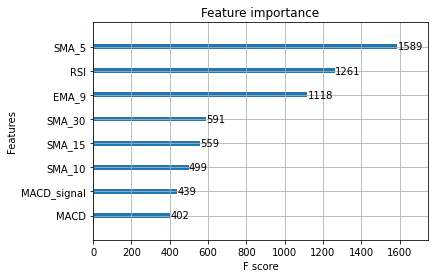

In [16]:
plot_importance(model);

For the trained XGBoost regression model, this code generates an importance plot. 
On the trained model object, "plot_importance" is called. XGBoost uses this function to visualize the importance of each feature in the model's predictions. 
This plot illustrates the relative importance of different features in influencing the model's predictions. Assigns importance scores to each feature based on its contribution to the model's performance. 
It is easier to identify the most influential features and understand their influence on the model's predictions by generating this plot. The model's output is more influenced by features with higher importance scores. 
The code generates an importance plot for the XGBoost regression model, allowing for visualization and interpretation of the relative importance of features.

Predictions can be calculated and visualized

In [17]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [31.73 32.84 32.7  32.52 32.37]
y_pred = [30.318808 30.329268 30.484104 30.875212 30.906727]


The code snippet generates predictions based on the trained XGBoost regression model and compares them with the actual target values. 
Using the test features (X_test) as input, the "predict" method is called on the trained model object. The provided test data is used to generate predicted values for the target variable. 
Variable y_pred represents the model's predictions for the target variable based on the test data. 
In the first five samples, the "print" function displays the actual target values (y_true). To display the first five values of the array, the np.array function is applied to the y_test variable. 
The "print" function displays the predicted values (y_pred) generated by the model for the first five samples. 
A quick comparison between the model's predictions and the actual values can be made by printing both the actual and predicted values. Predicting the target variable with this comparison helps evaluate the model's accuracy and performance. 
For the first five samples, this code generates predictions using the trained XGBoost regression model and displays the actual target values (y_true) as well as the predicted values (y_pred). By comparing the model's predictions with the true values, the accuracy and performance of the model can be evaluated directly.

In [18]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 3.7443482186887294


The following code snippet calculates and prints the mean squared error (MSE) between the actual target values (y_test) and the predicted values (y_pred). 
Scikit-learn's "mean_squared_error" function is called with the actual target values (y_test) and predicted values (y_pred). Mean squared error is a common metric used to evaluate regression model performance. 
"Print" displays the result of the mean squared error calculation. To include the computed mean squared error value in the output message, the f-string format is used. 
The mean squared error provides a quantitative measure of the accuracy of the model's predictions. Models with lower mean squared errors suggest better agreement between predicted and actual values. 
This code calculates the mean squared error between the actual target values and the predicted values based on the XGBoost regression model. A measure of the model's accuracy is provided by its mean squared error.

In [19]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

Based on the XGBoost regression model, this code generates a plot to compare predicted and actual stock prices. 
First, a copy of the DataFrame is created for the predicted prices, which corresponds to the original DataFrame after the test split index. As a result, the original DataFrame remains unchanged. 
After that, the 'Close' column of the predicted prices DataFrame is replaced with the predicted values (y_pred). 
The 'make_subplots' function creates a new figure object with two subplots. A different aspect of the data visualization is represented by each subplot. 
Using the 'add_trace' function, two scatter traces are added to the first subplot (row 1, column 1). 'Truth' represents the true prices from the original DataFrame, and 'Prediction' represents the predicted prices from the modified predicted prices DataFrame. The two traces are differentiated by different marker colors. 
Two scatter traces are added to the second subplot (row 2, column 1). There are two traces: one represents the true prices ('Truth') from the original test set (y_test), and one represents the predicted prices ('Prediction') from the model (y_pred). As the marker colors are consistent with the first subplot, a visual comparison can be made between the predicted and actual values. 
The plot is displayed using the 'show()' function, showing the true and predicted prices separately for visual analysis. 
Based on the XGBoost regression model, this code generates a plot that displays the true and predicted stock prices. It provides a visual evaluation of the model's performance by comparing true and predicted prices in subplots.